In [1]:
!pip install colab-xterm
%load_ext colabxterm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 KB 13.0 MB/s eta 0:00:00


In [2]:
from google.colab import drive
from pathlib import Path
import scipy.io
from glob import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import pandas as pd
from sklearn.preprocessing import normalize, label_binarize
from sklearn.model_selection import train_test_split, cross_val_score

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%xterm

Launching Xterm...

<IPython.core.display.Javascript object>

#1. Aquisição dos Dados

In [5]:
data = Path('drive/MyDrive/CNN_Chagas/Physionet/cnn-1d/data')

signals = []
classes =[]

for value in sorted(data.glob('*.mat')):
  signal = scipy.io.loadmat(value)
  signal = np.array(signal["val"], dtype='float')[0]
  signals.append(signal)
  # print(value)

In [6]:
classification_path = os.path.join(data, "classification.txt")
with open(classification_path) as f:
    classes = f.readlines()

for i in range(0, len(classes)):
  classes[i] = classes[i][classes[i].find(','):]
  classes[i] = classes[i][: classes[i].find('\n')]
  classes[i] = classes[i].replace(",", "")

# classes = classes[0: -1]

#2. Preprocessamento

### 2.1 Análise da distribuição das classes

In [7]:
d = {'signals': signals, 'classes': classes}
df = pd.DataFrame(data=d)
a = df.groupby('classes')

In [8]:
for i in ['N', 'O', 'A', '~']:
  print(i)
  aux = []

  for j in a.get_group(i)["signals"]:
    aux.append(len(j))

  print('Média:', round(np.mean(aux), 2))
  print("Std:", round(np.std(aux), 2))
  print("Qntd:", len(aux))
  print("Min:", min(aux))
  print("---------------")

N
Média: 9633.38
Std: 2991.84
Qntd: 5076
Min: 2714
---------------
O
Média: 10288.52
Std: 3528.74
Qntd: 2415
Min: 2738
---------------
A
Média: 9703.41
Std: 3694.64
Qntd: 758
Min: 2996
---------------
~
Média: 7313.63
Std: 3122.42
Qntd: 279
Min: 2808
---------------


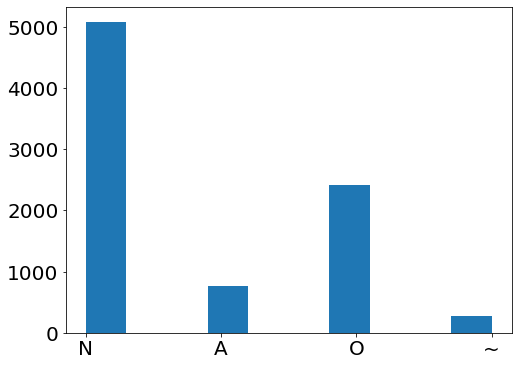

In [9]:
plt.rcParams.update({'font.size': 20})

df["classes"].hist(
    figsize=(8, 6),
    grid = False,
    bins = 10,
)
plt.xticks(range(4))
# plt.savefig('init_distri.png')
plt.show()

### 2.3 Wavelet helping functions

In [10]:
def gera_filtro_MH(Escala):
  passo = 1/Escala;
  X = []
  a = -5
  X.append(a)
  while a <= 5:
    a=a+passo
    X.append(a)
  Y = []
  for i in range(0,len(X)):
    Y.append(2.1741*(1/math.sqrt(2*math.pi) * (1 - X[i]**2) * np.exp(-X[i]**2/(2))))
  return Y

In [11]:
def apply_wavelet(signal, level):
  Filtro = gera_filtro_MH(level)
  y = np.convolve(signal,Filtro)
  return y

###2.4 Aplicação da tranformada Wavelet

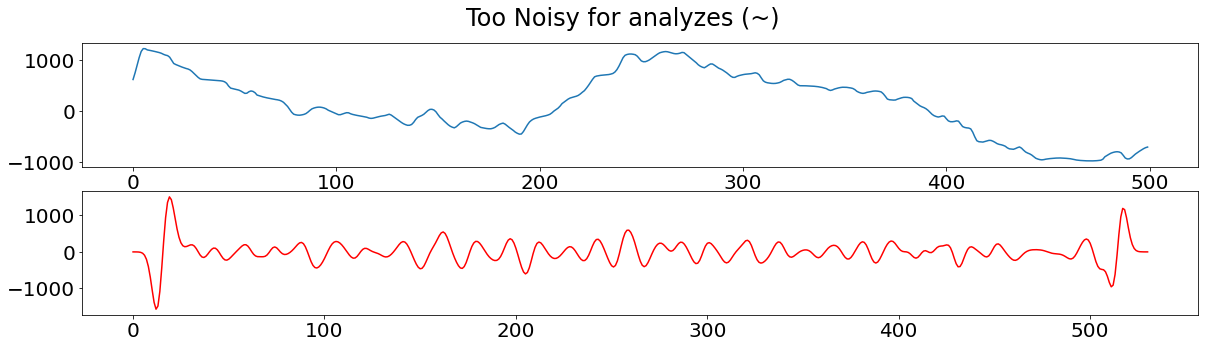

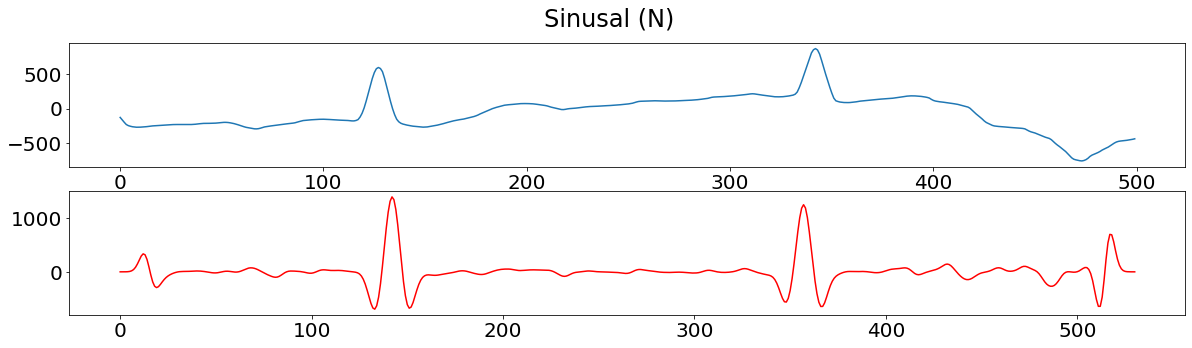

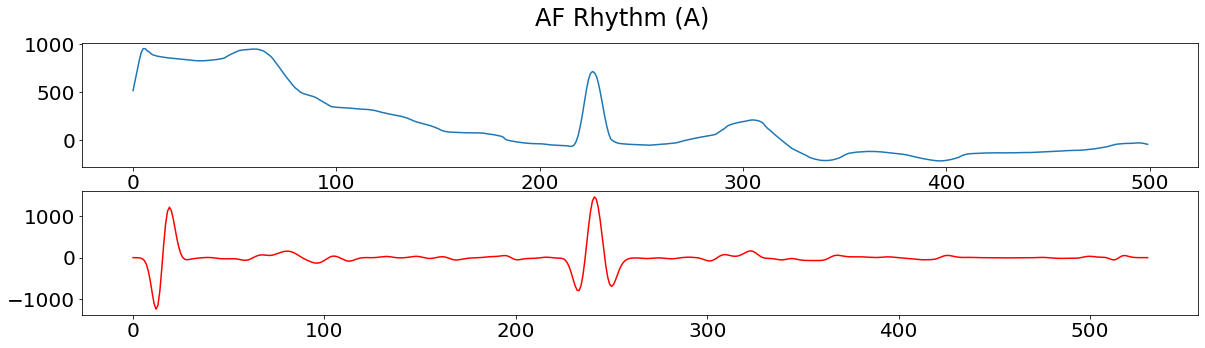

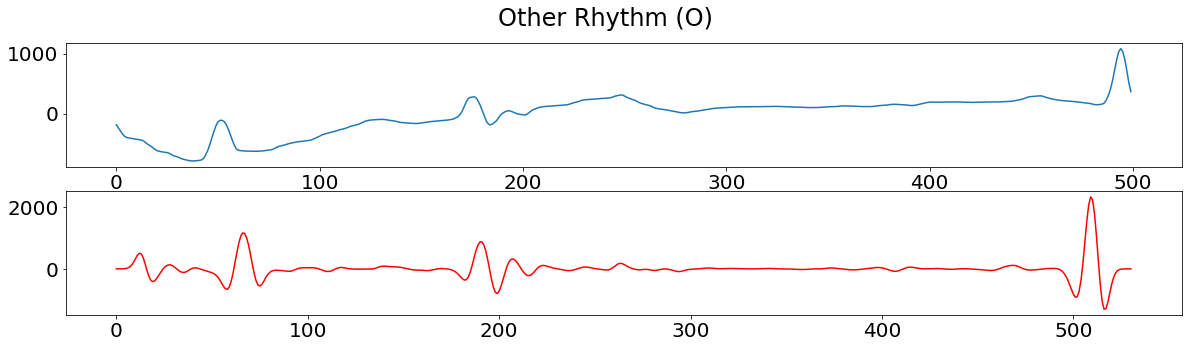

In [12]:
plt.rcParams['figure.figsize']=(20,5)

signal = df[df["classes"] == '~'].iloc[0]["signals"][0:500]
fig, ax = plt.subplots(2,1)
fig.suptitle("Too Noisy for analyzes (~)")
z = apply_wavelet(signal, 3)
ax[0].plot(signal)
ax[1].plot(z, 'r')
plt.show()

signal = df[df["classes"] == 'N'].iloc[0]["signals"][0:500]
fig, ax = plt.subplots(2,1)
fig.suptitle("Sinusal (N)")
z = apply_wavelet(signal, 3)
ax[0].plot(signal)
ax[1].plot(z, 'r')
plt.show()

signal = df[df["classes"] == 'A'].iloc[0]["signals"][0:500]
fig, ax = plt.subplots(2,1)
fig.suptitle("AF Rhythm (A)")
z = apply_wavelet(signal, 3)
ax[0].plot(signal)
ax[1].plot(z, 'r')
plt.show()

signal = df[df["classes"] == 'O'].iloc[0]["signals"][0:500]
fig, ax = plt.subplots(2,1)
fig.suptitle("Other Rhythm (O)")
z = apply_wavelet(signal, 3)
ax[0].plot(signal)
ax[1].plot(z, 'r')
plt.show()

In [13]:
x = []
for i in signals:
  val = apply_wavelet(i, 3)
  x.append(val)

### 2.2 Janelamento dos dados de treino

In [14]:
intersection = 100
window_size = 500
windows_array = ["max","max","max","max"]
classes_array = ['N', 'O', 'A', '~']

In [15]:
def window(signal, intersection, window_size, n):
  s_size = len(signal)
  max_n = (s_size-intersection)/(window_size - intersection)
  samples = []
  
  if  n == "max" or n > max_n:
    n = max_n
    n = math.floor(n)
    
  max_begin = s_size - (n*(window_size) - (n-1)*intersection)
  init = random.randrange(max_begin)
  for i in range(0, n):
    begin = init + i*window_size - i*intersection
    end = begin + window_size
    samples.append(signal[begin:end])

  
  return samples

In [16]:
def embalance_data(df, classes_array, windows_array, intersection, window_size):

  a = df.groupby('classes')
  d_train = df.copy()
  d_train = d_train.iloc[0:0]


  idx = -1
  for i in classes_array:
    aux = []
    idx += 1

    for index, row in a.get_group(i).iterrows():
      samples = window(row["signals"], intersection, window_size,  windows_array[idx])
      
      for k in range(len(samples)):
        d_train = d_train.append({'signals': samples[k], 'classes': i}, ignore_index=True)

  return d_train

In [17]:
x_rem, x_test, y_rem, y_test = train_test_split(x, df["classes"], test_size=0.25)
x_train, x_valid, y_train, y_valid = train_test_split(x_rem, y_rem, test_size=0.1)

d_aux_train = pd.DataFrame({'signals': x_train, 'classes': y_train})
d_train = embalance_data(d_aux_train, classes_array, windows_array, intersection, window_size)

d_aux_valid = pd.DataFrame({'signals': x_valid, 'classes': y_valid})
d_valid = embalance_data(d_aux_valid, classes_array, windows_array, intersection, window_size)

b = d_train.groupby('classes')

for i in ['N','O', 'A', '~']:
  print(i)
  aux = []

  for j in b.get_group(i)["signals"]:
    aux.append(len(j))

  print('Média:', round(np.mean(aux), 2))
  print("Std:", round(np.std(aux), 2))
  print("Qntd:", len(aux))
  print("Min:", min(aux))
  print("---------------")

N
Média: 500.0
Std: 0.0
Qntd: 80663
Min: 500
---------------
O
Média: 500.0
Std: 0.0
Qntd: 41692
Min: 500
---------------
A
Média: 500.0
Std: 0.0
Qntd: 11682
Min: 500
---------------
~
Média: 500.0
Std: 0.0
Qntd: 3157
Min: 500
---------------


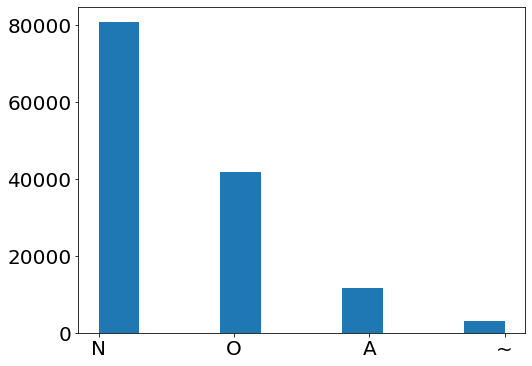

In [18]:
plt.rcParams.update({'font.size': 20})

d_train["classes"].hist(
    figsize=(8, 6),
    grid = False,
    bins = 10,
)
plt.xticks(range(4))
# plt.savefig('end_distri.png')
plt.show()

###2.4 "Normalização" do tamanho dos sinais

In [19]:
# for i in range(0, len(x)):
#   val = normalize([x[i]])
#   x[i] = val[0]

#3. Implementação da CNN

##3.1 Descoberta dos hyperparâmetros (Otimização Bayseana)

In [20]:
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers import Conv1D, MaxPooling1D

from keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl

In [21]:
y_train = pd.get_dummies(d_train["classes"])
y_valid = pd.get_dummies(d_valid["classes"])

x_train = list(d_train["signals"])
x_valid = list(d_valid["signals"])

x_train = np.array(x_train)
x_valid = np.array(x_valid)
x_test = np.array(x_test)

<ipython-input-21-d097fb1052ba>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_test = np.array(x_test)


In [22]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
# x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], 1)

In [23]:
# Import packages
from sklearn.model_selection import cross_val_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from math import floor
from sklearn.metrics import make_scorer, accuracy_score

pd.set_option("display.max_columns", None)

from sklearn import metrics
import tensorflow as tf

In [24]:
score_acc = make_scorer(accuracy_score)

In [25]:
len(x_train[0])

500

In [26]:
def dropout_test(dropout_rate):
  input_shape = len(x_train[0])
  k1 = 5
  k2 = 3
  n = math.floor(input_shape/(k1+k2-2))
  nn_input = input_shape % (k1+k2-2)

  classificador = Sequential()

  for i  in range(0, 5):
    if i == 0:
      classificador.add(Conv1D(filters=32, kernel_size = k1, input_shape = (input_shape, 1), activation = "relu"))
    else:
        classificador.add(Conv1D(filters=32, kernel_size = k1, activation = "relu"))

    classificador.add(Conv1D(filters=64, kernel_size = k2, activation = "relu"))

    classificador.add(MaxPooling1D(pool_size=2))

  classificador.add(Flatten())

  classificador.add(Dense(units=64, activation='relu'))
  Dropout(rate=dropout_rate)
  classificador.add(Dense(units=32, activation='relu'))
  Dropout(rate=dropout_rate)
  classificador.add(Dense(units=16, activation='relu'))
  Dropout(rate=dropout_rate)

  classificador.add(Dense(4, activation="softmax"))

  classificador.compile(loss='categorical_crossentropy', optimizer=Adamax(learning_rate=0.01), metrics=["accuracy"])


  es = EarlyStopping(monitor="accuracy", mode='max', verbose=0, patience=15)

  history = classificador.fit(x_train, y_train, validation_data=(x_valid, y_valid), epochs=150, batch_size=128, callbacks=es, verbose=1)

  

  return history


In [ ]:
dropout = np.arange(0.1, 1.0, 0.2)
best_val = 0

for i in dropout:
  history = dropout_test(i)
  
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'valid'], loc='upper left')
  # plt.savefig("neuron3.png")
  plt.show()

  score = max(history.history['val_accuracy'])

  if score > best_val:
    best_val = score
    drop = i

print(best_val)
print('------------------')
print(drop)

Epoch 1/150
1070/1073 [============================>.] - ETA: 0s - loss: 0.9037 - accuracy: 0.6115

1073/1073 [==============================] - 16s 14ms/step - loss: 0.9037 - accuracy: 0.6116 - val_loss: 0.8545 - val_accuracy: 0.6209
Epoch 2/150
1070/1073 [============================>.] - ETA: 0s - loss: 0.7960 - accuracy: 0.6591

1073/1073 [==============================] - 15s 14ms/step - loss: 0.7959 - accuracy: 0.6592 - val_loss: 0.8064 - val_accuracy: 0.6608
Epoch 3/150
1072/1073 [============================>.] - ETA: 0s - loss: 0.7605 - accuracy: 0.6773

1073/1073 [==============================] - 16s 15ms/step - loss: 0.7605 - accuracy: 0.6772 - val_loss: 0.7838 - val_accuracy: 0.6706
Epoch 4/150
1069/1073 [============================>.] - ETA: 0s - loss: 0.7394 - accuracy: 0.6895

1073/1073 [==============================] - 15s 14ms/step - loss: 0.7391 - accuracy: 0.6896 - val_loss: 0.7697 - val_accuracy: 0.6774
Epoch 5/150
1069/1073 [============================>.] - ETA: 0s - loss: 0.7247 - accuracy: 0.6963

1073/1073 [==============================] - 16s 15ms/step - loss: 0.7246 - accuracy: 0.6963 - val_loss: 0.7631 - val_accuracy: 0.6862
Epoch 6/150
1069/1073 [============================>.] - ETA: 0s - loss: 0.7124 - accuracy: 0.7038

1073/1073 [==============================] - 15s 14ms/step - loss: 0.7124 - accuracy: 0.7038 - val_loss: 0.7447 - val_accuracy: 0.6908
Epoch 7/150
1070/1073 [============================>.] - ETA: 0s - loss: 0.7018 - accuracy: 0.7087

1073/1073 [==============================] - 15s 14ms/step - loss: 0.7018 - accuracy: 0.7087 - val_loss: 0.7451 - val_accuracy: 0.6950
Epoch 8/150
1069/1073 [============================>.] - ETA: 0s - loss: 0.6953 - accuracy: 0.7119

1073/1073 [==============================] - 15s 14ms/step - loss: 0.6955 - accuracy: 0.7118 - val_loss: 0.7678 - val_accuracy: 0.6792
Epoch 9/150
1071/1073 [============================>.] - ETA: 0s - loss: 0.6899 - accuracy: 0.7137

1073/1073 [==============================] - 15s 14ms/step - loss: 0.6898 - accuracy: 0.7137 - val_loss: 0.7402 - val_accuracy: 0.6925
Epoch 10/150
1071/1073 [============================>.] - ETA: 0s - loss: 0.6823 - accuracy: 0.7191

1073/1073 [==============================] - 15s 14ms/step - loss: 0.6823 - accuracy: 0.7190 - val_loss: 0.7395 - val_accuracy: 0.6952
Epoch 11/150
1070/1073 [============================>.] - ETA: 0s - loss: 0.6756 - accuracy: 0.7220

1073/1073 [==============================] - 15s 14ms/step - loss: 0.6756 - accuracy: 0.7221 - val_loss: 0.7641 - val_accuracy: 0.6896
Epoch 12/150
1072/1073 [============================>.] - ETA: 0s - loss: 0.6697 - accuracy: 0.7236

1073/1073 [==============================] - 16s 15ms/step - loss: 0.6697 - accuracy: 0.7236 - val_loss: 0.7508 - val_accuracy: 0.6866
Epoch 13/150
1072/1073 [============================>.] - ETA: 0s - loss: 0.6624 - accuracy: 0.7278

1073/1073 [==============================] - 15s 14ms/step - loss: 0.6624 - accuracy: 0.7278 - val_loss: 0.7470 - val_accuracy: 0.6994
Epoch 14/150
1072/1073 [============================>.] - ETA: 0s - loss: 0.6572 - accuracy: 0.7306

1073/1073 [==============================] - 16s 15ms/step - loss: 0.6572 - accuracy: 0.7306 - val_loss: 0.7715 - val_accuracy: 0.6854
Epoch 15/150
1071/1073 [============================>.] - ETA: 0s - loss: 0.6520 - accuracy: 0.7334

1073/1073 [==============================] - 16s 15ms/step - loss: 0.6520 - accuracy: 0.7334 - val_loss: 0.7524 - val_accuracy: 0.6908
Epoch 16/150
1069/1073 [============================>.] - ETA: 0s - loss: 0.6462 - accuracy: 0.7362

1073/1073 [==============================] - 15s 14ms/step - loss: 0.6462 - accuracy: 0.7362 - val_loss: 0.7615 - val_accuracy: 0.6950
Epoch 17/150
1072/1073 [============================>.] - ETA: 0s - loss: 0.6421 - accuracy: 0.7375

1073/1073 [==============================] - 15s 14ms/step - loss: 0.6421 - accuracy: 0.7375 - val_loss: 0.7805 - val_accuracy: 0.6856
Epoch 18/150
1072/1073 [============================>.] - ETA: 0s - loss: 0.6381 - accuracy: 0.7403

1073/1073 [==============================] - 15s 14ms/step - loss: 0.6381 - accuracy: 0.7403 - val_loss: 0.7670 - val_accuracy: 0.6935
Epoch 19/150
1072/1073 [============================>.] - ETA: 0s - loss: 0.6340 - accuracy: 0.7422

1073/1073 [==============================] - 15s 14ms/step - loss: 0.6340 - accuracy: 0.7421 - val_loss: 0.7611 - val_accuracy: 0.6918
Epoch 20/150
1073/1073 [==============================] - ETA: 0s - loss: 0.6288 - accuracy: 0.7457

1073/1073 [==============================] - 15s 14ms/step - loss: 0.6288 - accuracy: 0.7457 - val_loss: 0.7776 - val_accuracy: 0.6914
Epoch 21/150
1073/1073 [==============================] - ETA: 0s - loss: 0.6262 - accuracy: 0.7451

1073/1073 [==============================] - 15s 14ms/step - loss: 0.6262 - accuracy: 0.7451 - val_loss: 0.7567 - val_accuracy: 0.6987
Epoch 22/150
1072/1073 [============================>.] - ETA: 0s - loss: 0.6201 - accuracy: 0.7484

1073/1073 [==============================] - 15s 14ms/step - loss: 0.6201 - accuracy: 0.7484 - val_loss: 0.7541 - val_accuracy: 0.6937
Epoch 23/150
1071/1073 [============================>.] - ETA: 0s - loss: 0.6169 - accuracy: 0.7488

1073/1073 [==============================] - 16s 15ms/step - loss: 0.6170 - accuracy: 0.7488 - val_loss: 0.7648 - val_accuracy: 0.6979
Epoch 24/150
1071/1073 [============================>.] - ETA: 0s - loss: 0.6098 - accuracy: 0.7531

1073/1073 [==============================] - 16s 15ms/step - loss: 0.6099 - accuracy: 0.7530 - val_loss: 0.7749 - val_accuracy: 0.6945
Epoch 25/150
1071/1073 [============================>.] - ETA: 0s - loss: 0.6059 - accuracy: 0.7554

1073/1073 [==============================] - 15s 14ms/step - loss: 0.6058 - accuracy: 0.7554 - val_loss: 0.7920 - val_accuracy: 0.6892
Epoch 26/150
1072/1073 [============================>.] - ETA: 0s - loss: 0.6001 - accuracy: 0.7578

1073/1073 [==============================] - 15s 14ms/step - loss: 0.6001 - accuracy: 0.7578 - val_loss: 0.7837 - val_accuracy: 0.6905
Epoch 27/150
1072/1073 [============================>.] - ETA: 0s - loss: 0.5989 - accuracy: 0.7578

1073/1073 [==============================] - 15s 14ms/step - loss: 0.5989 - accuracy: 0.7579 - val_loss: 0.7808 - val_accuracy: 0.6936
Epoch 28/150
1070/1073 [============================>.] - ETA: 0s - loss: 0.5927 - accuracy: 0.7605

1073/1073 [==============================] - 15s 14ms/step - loss: 0.5925 - accuracy: 0.7605 - val_loss: 0.7931 - val_accuracy: 0.6949
Epoch 29/150
1069/1073 [============================>.] - ETA: 0s - loss: 0.5900 - accuracy: 0.7607

1073/1073 [==============================] - 15s 14ms/step - loss: 0.5901 - accuracy: 0.7606 - val_loss: 0.7848 - val_accuracy: 0.6937
Epoch 30/150
1069/1073 [============================>.] - ETA: 0s - loss: 0.5855 - accuracy: 0.7636

1073/1073 [==============================] - 15s 14ms/step - loss: 0.5855 - accuracy: 0.7636 - val_loss: 0.7982 - val_accuracy: 0.6943
Epoch 31/150
1073/1073 [==============================] - ETA: 0s - loss: 0.5827 - accuracy: 0.7645

1073/1073 [==============================] - 16s 14ms/step - loss: 0.5827 - accuracy: 0.7645 - val_loss: 0.7915 - val_accuracy: 0.6884
Epoch 32/150
1072/1073 [============================>.] - ETA: 0s - loss: 0.5798 - accuracy: 0.7672

1073/1073 [==============================] - 15s 14ms/step - loss: 0.5798 - accuracy: 0.7672 - val_loss: 0.7929 - val_accuracy: 0.6933
Epoch 33/150
1072/1073 [============================>.] - ETA: 0s - loss: 0.5763 - accuracy: 0.7677

1073/1073 [==============================] - 15s 14ms/step - loss: 0.5763 - accuracy: 0.7677 - val_loss: 0.8083 - val_accuracy: 0.6906
Epoch 34/150
1072/1073 [============================>.] - ETA: 0s - loss: 0.5722 - accuracy: 0.7699

1073/1073 [==============================] - 15s 14ms/step - loss: 0.5722 - accuracy: 0.7699 - val_loss: 0.8136 - val_accuracy: 0.6850
Epoch 35/150
1071/1073 [============================>.] - ETA: 0s - loss: 0.5710 - accuracy: 0.7692

1073/1073 [==============================] - 15s 14ms/step - loss: 0.5709 - accuracy: 0.7692 - val_loss: 0.8053 - val_accuracy: 0.6899
Epoch 36/150
1072/1073 [============================>.] - ETA: 0s - loss: 0.5667 - accuracy: 0.7731

1073/1073 [==============================] - 15s 14ms/step - loss: 0.5667 - accuracy: 0.7731 - val_loss: 0.8073 - val_accuracy: 0.6841
Epoch 37/150
1072/1073 [============================>.] - ETA: 0s - loss: 0.5613 - accuracy: 0.7741

1073/1073 [==============================] - 15s 14ms/step - loss: 0.5613 - accuracy: 0.7741 - val_loss: 0.8576 - val_accuracy: 0.6884
Epoch 38/150
1070/1073 [============================>.] - ETA: 0s - loss: 0.5588 - accuracy: 0.7743

1073/1073 [==============================] - 16s 15ms/step - loss: 0.5587 - accuracy: 0.7743 - val_loss: 0.8546 - val_accuracy: 0.6880
Epoch 39/150
1072/1073 [============================>.] - ETA: 0s - loss: 0.5571 - accuracy: 0.7769

1073/1073 [==============================] - 15s 14ms/step - loss: 0.5572 - accuracy: 0.7768 - val_loss: 0.8137 - val_accuracy: 0.6825
Epoch 40/150
1070/1073 [============================>.] - ETA: 0s - loss: 0.5522 - accuracy: 0.7774

1073/1073 [==============================] - 15s 14ms/step - loss: 0.5520 - accuracy: 0.7775 - val_loss: 0.8492 - val_accuracy: 0.6870
Epoch 41/150
1071/1073 [============================>.] - ETA: 0s - loss: 0.5504 - accuracy: 0.7793

1073/1073 [==============================] - 16s 15ms/step - loss: 0.5504 - accuracy: 0.7793 - val_loss: 0.8354 - val_accuracy: 0.6893
Epoch 42/150
1070/1073 [============================>.] - ETA: 0s - loss: 0.5439 - accuracy: 0.7818

1073/1073 [==============================] - 15s 14ms/step - loss: 0.5439 - accuracy: 0.7818 - val_loss: 0.8311 - val_accuracy: 0.6902
Epoch 43/150
1069/1073 [============================>.] - ETA: 0s - loss: 0.5421 - accuracy: 0.7827

1073/1073 [==============================] - 15s 14ms/step - loss: 0.5422 - accuracy: 0.7826 - val_loss: 0.8420 - val_accuracy: 0.6727
Epoch 44/150
1069/1073 [============================>.] - ETA: 0s - loss: 0.5420 - accuracy: 0.7826

1073/1073 [==============================] - 15s 14ms/step - loss: 0.5418 - accuracy: 0.7826 - val_loss: 0.8723 - val_accuracy: 0.6831
Epoch 45/150
1073/1073 [==============================] - ETA: 0s - loss: 0.5360 - accuracy: 0.7861

1073/1073 [==============================] - 15s 14ms/step - loss: 0.5360 - accuracy: 0.7861 - val_loss: 0.8499 - val_accuracy: 0.6854
Epoch 46/150
1070/1073 [============================>.] - ETA: 0s - loss: 0.5276 - accuracy: 0.7884

1073/1073 [==============================] - 15s 14ms/step - loss: 0.5276 - accuracy: 0.7884 - val_loss: 0.8729 - val_accuracy: 0.6728
Epoch 47/150
1072/1073 [============================>.] - ETA: 0s - loss: 0.5299 - accuracy: 0.7875

1073/1073 [==============================] - 16s 15ms/step - loss: 0.5299 - accuracy: 0.7875 - val_loss: 0.8694 - val_accuracy: 0.6874
Epoch 48/150
1072/1073 [============================>.] - ETA: 0s - loss: 0.5266 - accuracy: 0.7880

1073/1073 [==============================] - 15s 14ms/step - loss: 0.5266 - accuracy: 0.7880 - val_loss: 0.8481 - val_accuracy: 0.6858
Epoch 49/150
1070/1073 [============================>.] - ETA: 0s - loss: 0.5229 - accuracy: 0.7913

1073/1073 [==============================] - 15s 14ms/step - loss: 0.5229 - accuracy: 0.7913 - val_loss: 0.9160 - val_accuracy: 0.6674
Epoch 50/150
1072/1073 [============================>.] - ETA: 0s - loss: 0.5195 - accuracy: 0.7924

1073/1073 [==============================] - 15s 14ms/step - loss: 0.5196 - accuracy: 0.7924 - val_loss: 0.8891 - val_accuracy: 0.6792
Epoch 51/150
1072/1073 [============================>.] - ETA: 0s - loss: 0.5171 - accuracy: 0.7944

1073/1073 [==============================] - 16s 15ms/step - loss: 0.5171 - accuracy: 0.7945 - val_loss: 0.8882 - val_accuracy: 0.6794
Epoch 52/150
1069/1073 [============================>.] - ETA: 0s - loss: 0.5159 - accuracy: 0.7939

1073/1073 [==============================] - 15s 14ms/step - loss: 0.5159 - accuracy: 0.7938 - val_loss: 0.9111 - val_accuracy: 0.6828
Epoch 53/150
1072/1073 [============================>.] - ETA: 0s - loss: 0.5111 - accuracy: 0.7955

1073/1073 [==============================] - 16s 15ms/step - loss: 0.5111 - accuracy: 0.7955 - val_loss: 0.8562 - val_accuracy: 0.6887
Epoch 54/150
1069/1073 [============================>.] - ETA: 0s - loss: 0.5062 - accuracy: 0.7977

1073/1073 [==============================] - 15s 14ms/step - loss: 0.5064 - accuracy: 0.7976 - val_loss: 0.8697 - val_accuracy: 0.6794
Epoch 55/150
1070/1073 [============================>.] - ETA: 0s - loss: 0.5082 - accuracy: 0.7965

1073/1073 [==============================] - 15s 14ms/step - loss: 0.5084 - accuracy: 0.7964 - val_loss: 0.9314 - val_accuracy: 0.6716
Epoch 56/150
1069/1073 [============================>.] - ETA: 0s - loss: 0.5052 - accuracy: 0.7973

1073/1073 [==============================] - 16s 14ms/step - loss: 0.5053 - accuracy: 0.7972 - val_loss: 0.9362 - val_accuracy: 0.6802
Epoch 57/150
1072/1073 [============================>.] - ETA: 0s - loss: 0.5002 - accuracy: 0.8008

1073/1073 [==============================] - 15s 14ms/step - loss: 0.5003 - accuracy: 0.8008 - val_loss: 0.8519 - val_accuracy: 0.6780
Epoch 58/150
1069/1073 [============================>.] - ETA: 0s - loss: 0.5041 - accuracy: 0.7992

1073/1073 [==============================] - 15s 14ms/step - loss: 0.5042 - accuracy: 0.7991 - val_loss: 0.9077 - val_accuracy: 0.6680
Epoch 59/150
1069/1073 [============================>.] - ETA: 0s - loss: 0.4995 - accuracy: 0.8005

1073/1073 [==============================] - 15s 14ms/step - loss: 0.4995 - accuracy: 0.8004 - val_loss: 0.8996 - val_accuracy: 0.6810
Epoch 60/150
1070/1073 [============================>.] - ETA: 0s - loss: 0.4940 - accuracy: 0.8029

1073/1073 [==============================] - 15s 14ms/step - loss: 0.4941 - accuracy: 0.8029 - val_loss: 0.9385 - val_accuracy: 0.6767
Epoch 61/150
1071/1073 [============================>.] - ETA: 0s - loss: 0.4891 - accuracy: 0.8048

1073/1073 [==============================] - 15s 14ms/step - loss: 0.4893 - accuracy: 0.8048 - val_loss: 0.9674 - val_accuracy: 0.6747
Epoch 62/150
1071/1073 [============================>.] - ETA: 0s - loss: 0.4917 - accuracy: 0.8036

1073/1073 [==============================] - 15s 14ms/step - loss: 0.4918 - accuracy: 0.8036 - val_loss: 0.9079 - val_accuracy: 0.6758
Epoch 63/150
1072/1073 [============================>.] - ETA: 0s - loss: 0.4859 - accuracy: 0.8065

1073/1073 [==============================] - 15s 14ms/step - loss: 0.4859 - accuracy: 0.8065 - val_loss: 0.9197 - val_accuracy: 0.6762
Epoch 64/150
1071/1073 [============================>.] - ETA: 0s - loss: 0.4885 - accuracy: 0.8051

1073/1073 [==============================] - 16s 15ms/step - loss: 0.4885 - accuracy: 0.8051 - val_loss: 0.9358 - val_accuracy: 0.6762
Epoch 65/150
1072/1073 [============================>.] - ETA: 0s - loss: 0.4833 - accuracy: 0.8083

1073/1073 [==============================] - 15s 14ms/step - loss: 0.4834 - accuracy: 0.8083 - val_loss: 0.9029 - val_accuracy: 0.6627
Epoch 66/150
1069/1073 [============================>.] - ETA: 0s - loss: 0.4813 - accuracy: 0.8094

1073/1073 [==============================] - 15s 14ms/step - loss: 0.4814 - accuracy: 0.8093 - val_loss: 0.9216 - val_accuracy: 0.6756
Epoch 67/150
1071/1073 [============================>.] - ETA: 0s - loss: 0.4755 - accuracy: 0.8105

1073/1073 [==============================] - 15s 14ms/step - loss: 0.4755 - accuracy: 0.8104 - val_loss: 0.9490 - val_accuracy: 0.6738
Epoch 68/150
1070/1073 [============================>.] - ETA: 0s - loss: 0.4739 - accuracy: 0.8108

1073/1073 [==============================] - 15s 14ms/step - loss: 0.4740 - accuracy: 0.8108 - val_loss: 0.9647 - val_accuracy: 0.6737
Epoch 69/150
1071/1073 [============================>.] - ETA: 0s - loss: 0.4678 - accuracy: 0.8143

1073/1073 [==============================] - 15s 14ms/step - loss: 0.4678 - accuracy: 0.8144 - val_loss: 1.0019 - val_accuracy: 0.6796
Epoch 70/150
1069/1073 [============================>.] - ETA: 0s - loss: 0.4636 - accuracy: 0.8163

1073/1073 [==============================] - 15s 14ms/step - loss: 0.4636 - accuracy: 0.8163 - val_loss: 1.0499 - val_accuracy: 0.6599
Epoch 71/150
1072/1073 [============================>.] - ETA: 0s - loss: 0.4668 - accuracy: 0.8145

1073/1073 [==============================] - 15s 14ms/step - loss: 0.4669 - accuracy: 0.8145 - val_loss: 1.0454 - val_accuracy: 0.6750
Epoch 72/150
1069/1073 [============================>.] - ETA: 0s - loss: 0.4614 - accuracy: 0.8177

1073/1073 [==============================] - 15s 14ms/step - loss: 0.4615 - accuracy: 0.8177 - val_loss: 1.0132 - val_accuracy: 0.6618
Epoch 73/150
1073/1073 [==============================] - ETA: 0s - loss: 0.4566 - accuracy: 0.8195

1073/1073 [==============================] - 15s 14ms/step - loss: 0.4566 - accuracy: 0.8195 - val_loss: 0.9776 - val_accuracy: 0.6599
Epoch 74/150
1069/1073 [============================>.] - ETA: 0s - loss: 0.4596 - accuracy: 0.8179

1073/1073 [==============================] - 15s 14ms/step - loss: 0.4598 - accuracy: 0.8179 - val_loss: 0.9802 - val_accuracy: 0.6685
Epoch 75/150
1071/1073 [============================>.] - ETA: 0s - loss: 0.4564 - accuracy: 0.8186

1073/1073 [==============================] - 15s 14ms/step - loss: 0.4564 - accuracy: 0.8187 - val_loss: 0.9831 - val_accuracy: 0.6762
Epoch 76/150
1072/1073 [============================>.] - ETA: 0s - loss: 0.4568 - accuracy: 0.8187

1073/1073 [==============================] - 16s 14ms/step - loss: 0.4568 - accuracy: 0.8187 - val_loss: 1.0023 - val_accuracy: 0.6718
Epoch 77/150
1071/1073 [============================>.] - ETA: 0s - loss: 0.4507 - accuracy: 0.8220

1073/1073 [==============================] - 15s 14ms/step - loss: 0.4507 - accuracy: 0.8220 - val_loss: 0.9533 - val_accuracy: 0.6697
Epoch 78/150
1072/1073 [============================>.] - ETA: 0s - loss: 0.4506 - accuracy: 0.8210

1073/1073 [==============================] - 15s 14ms/step - loss: 0.4507 - accuracy: 0.8209 - val_loss: 0.9421 - val_accuracy: 0.6728
Epoch 79/150
1070/1073 [============================>.] - ETA: 0s - loss: 0.4495 - accuracy: 0.8227

1073/1073 [==============================] - 15s 14ms/step - loss: 0.4495 - accuracy: 0.8227 - val_loss: 1.0455 - val_accuracy: 0.6732
Epoch 80/150
1070/1073 [============================>.] - ETA: 0s - loss: 0.4437 - accuracy: 0.8248

1073/1073 [==============================] - 15s 14ms/step - loss: 0.4435 - accuracy: 0.8249 - val_loss: 1.0748 - val_accuracy: 0.6768
Epoch 81/150
1070/1073 [============================>.] - ETA: 0s - loss: 0.4450 - accuracy: 0.8245

1073/1073 [==============================] - 15s 14ms/step - loss: 0.4453 - accuracy: 0.8245 - val_loss: 1.0231 - val_accuracy: 0.6667
Epoch 82/150
1072/1073 [============================>.] - ETA: 0s - loss: 0.4431 - accuracy: 0.8254

1073/1073 [==============================] - 15s 14ms/step - loss: 0.4431 - accuracy: 0.8254 - val_loss: 0.9886 - val_accuracy: 0.6772
Epoch 83/150
1071/1073 [============================>.] - ETA: 0s - loss: 0.4405 - accuracy: 0.8269

1073/1073 [==============================] - 15s 14ms/step - loss: 0.4404 - accuracy: 0.8269 - val_loss: 1.0501 - val_accuracy: 0.6624
Epoch 84/150
1070/1073 [============================>.] - ETA: 0s - loss: 0.4412 - accuracy: 0.8258

1073/1073 [==============================] - 15s 14ms/step - loss: 0.4411 - accuracy: 0.8258 - val_loss: 1.0153 - val_accuracy: 0.6706
Epoch 85/150
1070/1073 [============================>.] - ETA: 0s - loss: 0.4385 - accuracy: 0.8269

1073/1073 [==============================] - 15s 14ms/step - loss: 0.4385 - accuracy: 0.8268 - val_loss: 1.0514 - val_accuracy: 0.6590
Epoch 86/150
1070/1073 [============================>.] - ETA: 0s - loss: 0.4294 - accuracy: 0.8315

1073/1073 [==============================] - 15s 14ms/step - loss: 0.4295 - accuracy: 0.8314 - val_loss: 1.0085 - val_accuracy: 0.6714
Epoch 87/150
1070/1073 [============================>.] - ETA: 0s - loss: 0.4317 - accuracy: 0.8303

1073/1073 [==============================] - 15s 14ms/step - loss: 0.4317 - accuracy: 0.8303 - val_loss: 1.0633 - val_accuracy: 0.6686
Epoch 88/150
1072/1073 [============================>.] - ETA: 0s - loss: 0.4294 - accuracy: 0.8328

1073/1073 [==============================] - 15s 14ms/step - loss: 0.4294 - accuracy: 0.8328 - val_loss: 1.0619 - val_accuracy: 0.6606
Epoch 89/150
1070/1073 [============================>.] - ETA: 0s - loss: 0.4232 - accuracy: 0.8338

1073/1073 [==============================] - 15s 14ms/step - loss: 0.4232 - accuracy: 0.8338 - val_loss: 1.1448 - val_accuracy: 0.6634
Epoch 90/150
1070/1073 [============================>.] - ETA: 0s - loss: 0.4273 - accuracy: 0.8323

1073/1073 [==============================] - 15s 14ms/step - loss: 0.4275 - accuracy: 0.8322 - val_loss: 1.0708 - val_accuracy: 0.6630
Epoch 91/150
1070/1073 [============================>.] - ETA: 0s - loss: 0.4195 - accuracy: 0.8356

1073/1073 [==============================] - 15s 14ms/step - loss: 0.4194 - accuracy: 0.8356 - val_loss: 1.1200 - val_accuracy: 0.6729
Epoch 92/150
1070/1073 [============================>.] - ETA: 0s - loss: 0.4212 - accuracy: 0.8345

1073/1073 [==============================] - 15s 14ms/step - loss: 0.4213 - accuracy: 0.8345 - val_loss: 1.0377 - val_accuracy: 0.6658
Epoch 93/150
1069/1073 [============================>.] - ETA: 0s - loss: 0.4237 - accuracy: 0.8341

1073/1073 [==============================] - 15s 14ms/step - loss: 0.4236 - accuracy: 0.8341 - val_loss: 1.0759 - val_accuracy: 0.6692
Epoch 94/150
1072/1073 [============================>.] - ETA: 0s - loss: 0.4219 - accuracy: 0.8348

1073/1073 [==============================] - 15s 14ms/step - loss: 0.4219 - accuracy: 0.8348 - val_loss: 1.0309 - val_accuracy: 0.6694
Epoch 95/150
1071/1073 [============================>.] - ETA: 0s - loss: 0.4174 - accuracy: 0.8364

1073/1073 [==============================] - 15s 14ms/step - loss: 0.4174 - accuracy: 0.8363 - val_loss: 1.1384 - val_accuracy: 0.6579
Epoch 96/150
1070/1073 [============================>.] - ETA: 0s - loss: 0.4200 - accuracy: 0.8354

1073/1073 [==============================] - 15s 14ms/step - loss: 0.4201 - accuracy: 0.8354 - val_loss: 1.0422 - val_accuracy: 0.6634
Epoch 97/150
1072/1073 [============================>.] - ETA: 0s - loss: 0.4207 - accuracy: 0.8363

1073/1073 [==============================] - 15s 14ms/step - loss: 0.4208 - accuracy: 0.8363 - val_loss: 1.0648 - val_accuracy: 0.6676
Epoch 98/150
1069/1073 [============================>.] - ETA: 0s - loss: 0.4107 - accuracy: 0.8393

1073/1073 [==============================] - 15s 14ms/step - loss: 0.4106 - accuracy: 0.8393 - val_loss: 1.1331 - val_accuracy: 0.6552
Epoch 99/150
1070/1073 [============================>.] - ETA: 0s - loss: 0.4110 - accuracy: 0.8403

1073/1073 [==============================] - 15s 14ms/step - loss: 0.4111 - accuracy: 0.8402 - val_loss: 1.0415 - val_accuracy: 0.6632
Epoch 100/150
1069/1073 [============================>.] - ETA: 0s - loss: 0.4089 - accuracy: 0.8409

1073/1073 [==============================] - 15s 14ms/step - loss: 0.4089 - accuracy: 0.8409 - val_loss: 1.1212 - val_accuracy: 0.6625
Epoch 101/150
1071/1073 [============================>.] - ETA: 0s - loss: 0.4096 - accuracy: 0.8396

1073/1073 [==============================] - 15s 14ms/step - loss: 0.4097 - accuracy: 0.8396 - val_loss: 1.1268 - val_accuracy: 0.6647
Epoch 102/150
1070/1073 [============================>.] - ETA: 0s - loss: 0.4065 - accuracy: 0.8414

1073/1073 [==============================] - 15s 14ms/step - loss: 0.4066 - accuracy: 0.8413 - val_loss: 1.1382 - val_accuracy: 0.6662
Epoch 103/150
1072/1073 [============================>.] - ETA: 0s - loss: 0.4011 - accuracy: 0.8430

1073/1073 [==============================] - 15s 14ms/step - loss: 0.4011 - accuracy: 0.8430 - val_loss: 1.1418 - val_accuracy: 0.6687
Epoch 104/150
1069/1073 [============================>.] - ETA: 0s - loss: 0.4046 - accuracy: 0.8415

1073/1073 [==============================] - 15s 14ms/step - loss: 0.4046 - accuracy: 0.8416 - val_loss: 1.0803 - val_accuracy: 0.6732
Epoch 105/150
1072/1073 [============================>.] - ETA: 0s - loss: 0.4058 - accuracy: 0.8418

1073/1073 [==============================] - 15s 14ms/step - loss: 0.4058 - accuracy: 0.8418 - val_loss: 1.1046 - val_accuracy: 0.6697
Epoch 106/150
1070/1073 [============================>.] - ETA: 0s - loss: 0.3965 - accuracy: 0.8445

1073/1073 [==============================] - 15s 14ms/step - loss: 0.3965 - accuracy: 0.8445 - val_loss: 1.1479 - val_accuracy: 0.6603
Epoch 107/150
1070/1073 [============================>.] - ETA: 0s - loss: 0.3988 - accuracy: 0.8447

1073/1073 [==============================] - 15s 14ms/step - loss: 0.3989 - accuracy: 0.8446 - val_loss: 1.1721 - val_accuracy: 0.6659
Epoch 108/150
1072/1073 [============================>.] - ETA: 0s - loss: 0.4025 - accuracy: 0.8431

1073/1073 [==============================] - 15s 14ms/step - loss: 0.4025 - accuracy: 0.8431 - val_loss: 1.1002 - val_accuracy: 0.6553
Epoch 109/150
1070/1073 [============================>.] - ETA: 0s - loss: 0.3958 - accuracy: 0.8456

1073/1073 [==============================] - 16s 15ms/step - loss: 0.3959 - accuracy: 0.8455 - val_loss: 1.1826 - val_accuracy: 0.6621
Epoch 110/150
1071/1073 [============================>.] - ETA: 0s - loss: 0.3972 - accuracy: 0.8449

1073/1073 [==============================] - 15s 14ms/step - loss: 0.3972 - accuracy: 0.8449 - val_loss: 1.1794 - val_accuracy: 0.6588
Epoch 111/150
1072/1073 [============================>.] - ETA: 0s - loss: 0.3907 - accuracy: 0.8469

1073/1073 [==============================] - 15s 14ms/step - loss: 0.3907 - accuracy: 0.8469 - val_loss: 1.1182 - val_accuracy: 0.6480
Epoch 112/150
1070/1073 [============================>.] - ETA: 0s - loss: 0.3842 - accuracy: 0.8502

1073/1073 [==============================] - 15s 14ms/step - loss: 0.3841 - accuracy: 0.8502 - val_loss: 1.1673 - val_accuracy: 0.6694
Epoch 113/150
1072/1073 [============================>.] - ETA: 0s - loss: 0.3863 - accuracy: 0.8500

1073/1073 [==============================] - 15s 14ms/step - loss: 0.3863 - accuracy: 0.8500 - val_loss: 1.1522 - val_accuracy: 0.6643
Epoch 114/150
1069/1073 [============================>.] - ETA: 0s - loss: 0.3879 - accuracy: 0.8492

1073/1073 [==============================] - 15s 14ms/step - loss: 0.3879 - accuracy: 0.8492 - val_loss: 1.2645 - val_accuracy: 0.6667
Epoch 115/150
1072/1073 [============================>.] - ETA: 0s - loss: 0.3949 - accuracy: 0.8463

1073/1073 [==============================] - 15s 14ms/step - loss: 0.3948 - accuracy: 0.8464 - val_loss: 1.1089 - val_accuracy: 0.6634
Epoch 116/150
1069/1073 [============================>.] - ETA: 0s - loss: 0.3863 - accuracy: 0.8499

1073/1073 [==============================] - 15s 14ms/step - loss: 0.3866 - accuracy: 0.8498 - val_loss: 1.1927 - val_accuracy: 0.6625
Epoch 117/150
1070/1073 [============================>.] - ETA: 0s - loss: 0.3851 - accuracy: 0.8511

1073/1073 [==============================] - 15s 14ms/step - loss: 0.3849 - accuracy: 0.8511 - val_loss: 1.2614 - val_accuracy: 0.6630
Epoch 118/150
1070/1073 [============================>.] - ETA: 0s - loss: 0.3780 - accuracy: 0.8534

1073/1073 [==============================] - 15s 14ms/step - loss: 0.3780 - accuracy: 0.8533 - val_loss: 1.2363 - val_accuracy: 0.6383
Epoch 119/150
1070/1073 [============================>.] - ETA: 0s - loss: 0.3831 - accuracy: 0.8515

1073/1073 [==============================] - 15s 14ms/step - loss: 0.3832 - accuracy: 0.8515 - val_loss: 1.1365 - val_accuracy: 0.6666
Epoch 120/150
 416/1073 [==========>...................] - ETA: 8s - loss: 0.3683 - accuracy: 0.8565

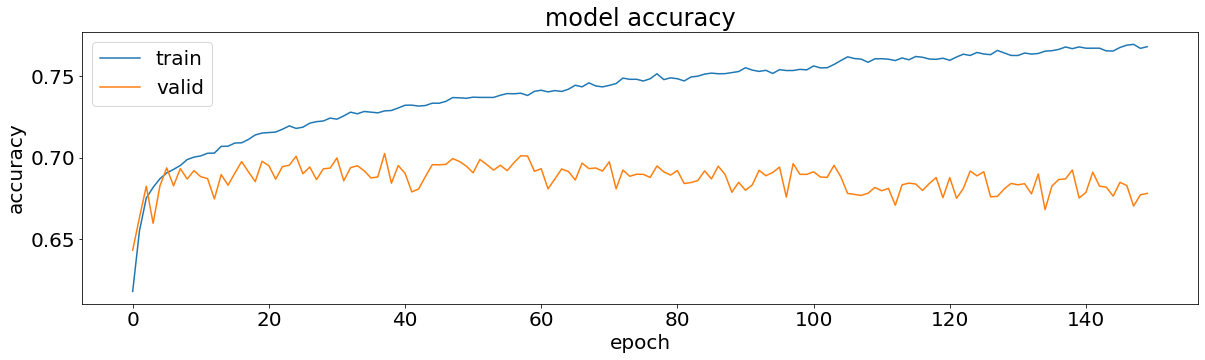

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.savefig("neuron3.png")
plt.show()

In [ ]:
from sklearn.utils.extmath import weighted_mode
from bayes_opt import BayesianOptimization

In [ ]:
dt = pd.concat([d_aux_valid, d_aux_train], ignore_index=True)
max_val = 0
count = 0

In [ ]:
def weighted_mode(df):
  x_nn = []
  x = df["signals"]
  y_nn = df["classes"]

  for signal in x:
    samples = window(signal, intersection, window_size, "max")
    samples = np.array(samples)
    samples = samples.reshape(samples.shape[0],samples.shape[1], 1)
    
    prediction = classificador.predict(samples)
    prediction = pd.DataFrame(prediction)
    prediction.columns = ['A', 'N', 'O', '~']
    prediction = prediction.idxmax(axis=1)
    prediction = list(prediction)
    w_array = np.zeros(4)
    for i in prediction:
      if i == "A":
        w_array[0] += 1
      elif i == "N":
        w_array[1] += 1
      elif i == "O":
        w_array[2] += 1
      elif i == "~":
        w_array[3] += 1
    
    w_array = list(w_array)
    x_nn.append(w_array)

  return x_nn, y_nn
    

In [ ]:
x_nn, y_nn = weighted_mode(dt)

A saída de streaming foi truncada nas últimas 5000 linhas.
1/1 [==============================] - 0s 23ms/step


In [ ]:
def evaluate(w_a, w_o, w_n, w_til):
  global count
  global max_val

  if count == 15:
    return max_val

  y_pred = []
  columns = ['A', 'N', 'O', '~']

  for signal in x_nn:
    signal = np.multiply(signal, [w_a, w_n, w_o, w_til])
    signal = list(signal)
    index = signal.index(max(signal))
    y_pred.append(columns[index])

  score = accuracy_score(y_nn, y_pred)

  if max_val < score:
    max_val = score
    count = 0
  else:
    count += 1

  return score

In [ ]:
pbounds = {'w_a': (0, 10), 
           'w_o': (0, 10),
           'w_n': (0, 10),
           'w_til': (0, 10)}

optimizer = BayesianOptimization(
    f=evaluate,
    pbounds=pbounds,
    random_state=1,
    verbose=2,
)

In [ ]:
optimizer.maximize(init_points=15, n_iter=60)

|   iter    |  target   |    w_a    |    w_n    |    w_o    |   w_til   |
-------------------------------------------------------------------------
| 1         | 0.6585    | 4.17      | 7.203     | 0.001144  | 3.023     |
| 2         | 0.7944    | 1.468     | 0.9234    | 1.863     | 3.456     |
| 3         | 0.7467    | 3.968     | 5.388     | 4.192     | 6.852     |
| 4         | 0.6524    | 2.045     | 8.781     | 0.2739    | 6.705     |
| 5         | 0.7076    | 4.173     | 5.587     | 1.404     | 1.981     |
| 6         | 0.7161    | 8.007     | 9.683     | 3.134     | 6.923     |
| 7         | 0.6829    | 8.764     | 8.946     | 0.8504    | 0.3905    |
| 8         | 0.6643    | 1.698     | 8.781     | 0.9835    | 4.211     |
| 9         | 0.7706    | 9.579     | 5.332     | 6.919     | 3.155     |
| 10        | 0.6678    | 6.865     | 8.346     | 0.1829    | 7.501     |
| 11        | 0.7231    | 9.889     | 7.482     | 2.804     | 7.893     |
| 12        | 0.7477    | 1.032     | 

In [ ]:
print(optimizer.max)

{'target': 0.8134771732332708, 'params': {'w_a': 5.741176054920131, 'w_n': 1.4672857490581015, 'w_o': 5.893055369032842, 'w_til': 6.997583600209312}}


In [ ]:
params = optimizer.max["params"]
w_o = params["w_o"]
w_a = params["w_a"]
w_n = params["w_n"]
w_til = params["w_til"]

## 4. Verificando  a precisão com os dados de teste

In [ ]:
y_pred = []
for signal in x_test:
  samples = window(signal, intersection, window_size, "max")
  samples = np.array(samples)
  samples = samples.reshape(samples.shape[0],samples.shape[1], 1)
  
  prediction = classificador.predict(samples)
  prediction = pd.DataFrame(prediction)
  prediction.columns = ['A', 'N', 'O', '~']
  prediction = prediction.idxmax(axis=1)
  prediction = list(prediction)

  w_array = np.zeros(4)
  for i in prediction:
    if i == "O":
      w_array[2] += w_o
    elif i == "A":
      w_array[0] += w_a
    elif i == "N":
      w_array[1] += w_n
    elif i == "~":
      w_array[3] += w_til
  
  w_array = list(w_array)
  index = w_array.index(max(w_array))
  columns = ['A', 'N', 'O', '~']
  y_pred.append(columns[index])



1/1 [==============================] - 0s 17ms/step


In [ ]:
# y_pred = classificador.predict(x_test)
# y_pred = pd.DataFrame(y_pred)
# y_pred.columns = ['A', 'N', 'O', '~']

In [ ]:
# y_test = y_test.idxmax(axis=1)
# # y_pred = y_pred.idxmax(axis=1)

In [ ]:
accuracy_score(y_test, y_pred)
# score = cross_val_score(classificador, x_valid, y_valid, scoring=score_acc, cv=5)

# media = score.mean()
# std = score.std()

0.7626641651031895

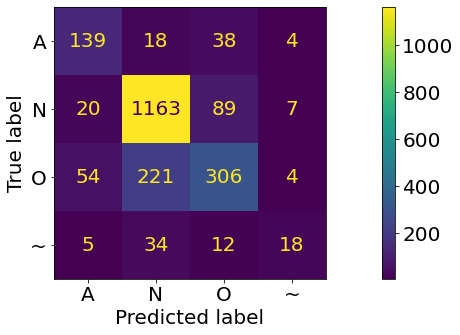

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics

cf_matrix = confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cf_matrix, display_labels = ['A', 'N', 'O', '~'])
cm_display.plot()
plt.savefig("test.png")

In [ ]:
accuracy_score(y_test, y_pred)

0.7626641651031895